<a href="https://colab.research.google.com/github/karthik-653/Analytics-Arena/blob/main/SIR_FSRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from PIL import Image
import os
import numpy as np
import random
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import albumentations as A
import sys
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, InputLayer, PReLU, Activation, Lambda, Reshape
from tensorflow.keras import initializers
import argparse
import pandas as pd
#from IPython.display import Image, display
import re
import cv2
import matplotlib.pyplot as plt
import h5py


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/AnalyticsArena_DataSet/HighResolution_Train'

model_d = 56
model_s =12
model_m =4

lr_init = 0.001
epochs = 50
batch_size = 30
steps_per_epoch = 20
val_batch_size = 20
validation_steps = 4

weights_fn =  "/content/drive/MyDrive/AnalyticsArena_DataSet/fsrcnn_hope/model_{epoch:05d}.h5"

In [ ]:
IMAGE_FORMAT = ".jpg"
DOWNSAMPLE_MODE = Image.BICUBIC
COLOR_CHANNELS = 3

HR_IMG_SIZE = (510, 510)
UPSCALING_FACTOR = 3
LR_IMG_SIZE = (HR_IMG_SIZE[0] // UPSCALING_FACTOR, HR_IMG_SIZE[1] // UPSCALING_FACTOR)

In [ ]:
class Image_Dataset(keras.utils.Sequence):
    def __init__(self, hr_image_folder: str, batch_size: int, set_type: str):
        self.batch_size = batch_size
        self.hr_image_folder = hr_image_folder
        self.image_fns = np.sort([
            x for x in os.listdir(hr_image_folder) if x.endswith(IMAGE_FORMAT)
        ])
        
        if set_type == "train":
            self.image_fns = self.image_fns[:-500]
        elif set_type == "val":
            self.image_fns = self.image_fns[-500:-200]
        else:
            self.image_fns = self.image_fns[-200:]
            
        if set_type in ["train", "val"]:
            self.transform = A.Compose(
                [
                    A.RandomCrop(width=HR_IMG_SIZE[0], height=HR_IMG_SIZE[1], p=1.0),
                    A.HorizontalFlip(p=0.5),
                    A.ColorJitter(
                        brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=0.8
                    ),
                ]
            )
        else: 
            self.transform = A.Compose(
                [
                    A.RandomCrop(width=HR_IMG_SIZE[0], height=HR_IMG_SIZE[1], p=1.0),
                ]
            )
                    
        self.to_float = A.ToFloat(max_value=255)

    def __len__(self):
        return len(self.image_fns) // self.batch_size

    def on_epoch_end(self):
        random.shuffle(self.image_fns)

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_image_fns = self.image_fns[i : i + self.batch_size]
        batch_hr_images = np.zeros((self.batch_size,) + HR_IMG_SIZE + (COLOR_CHANNELS,))
        batch_lr_images = np.zeros((self.batch_size,) + LR_IMG_SIZE + (COLOR_CHANNELS,))

        for i, image_fn in enumerate(batch_image_fns):
            hr_image_pil = Image.open(os.path.join(self.hr_image_folder, image_fn))
            hr_image = np.array(hr_image_pil)
            
            hr_image_transform = self.transform(image=hr_image)["image"]
            hr_image_transform_pil = Image.fromarray(hr_image_transform)
            lr_image_transform_pil = hr_image_transform_pil.resize(
                LR_IMG_SIZE, resample=DOWNSAMPLE_MODE
            )
            lr_image_transform = np.array(lr_image_transform_pil)

            batch_hr_images[i] = self.to_float(image=hr_image_transform)["image"]
            batch_lr_images[i] = self.to_float(image=lr_image_transform)["image"]

        return (batch_lr_images, batch_hr_images)

In [ ]:
def create_model(
    d: int,
    s: int,
    m: int,
    input_size: tuple = LR_IMG_SIZE,
    upscaling_factor: int = UPSCALING_FACTOR,
    color_channels: int = COLOR_CHANNELS,
):
    model = Sequential()
    model.add(InputLayer(input_shape=(input_size[0], input_size[1], color_channels)))

    # feature extraction
    model.add(
        Conv2D(
            kernel_size=5,
            filters=d,
            padding="same",
            kernel_initializer=initializers.HeNormal(),
        )
    )
    model.add(PReLU(alpha_initializer="zeros", shared_axes=[1, 2]))

    # shrinking
    model.add(
        Conv2D(
            kernel_size=1,
            filters=s,
            padding="same",
            kernel_initializer=initializers.HeNormal(),
        )
    )
    model.add(PReLU(alpha_initializer="zeros", shared_axes=[1, 2]))

    # mapping
    for _ in range(m):
        model.add(
            Conv2D(
                kernel_size=3,
                filters=s,
                padding="same",
                kernel_initializer=initializers.HeNormal(),
            )
        )
        model.add(PReLU(alpha_initializer="zeros", shared_axes=[1, 2]))

    # expanding
    model.add(Conv2D(kernel_size=1, filters=d, padding="same"))
    model.add(PReLU(alpha_initializer="zeros", shared_axes=[1, 2]))

    # deconvolution
    model.add(
        Conv2DTranspose(
            kernel_size=9,
            filters=color_channels,
            strides=upscaling_factor,
            padding="same",
            kernel_initializer=initializers.RandomNormal(mean=0, stddev=0.001),
        )
    )

    return model

In [ ]:
def train() -> None:

    train_dataset = Image_Dataset(
        hr_image_folder=data_path,
        batch_size = batch_size,
        set_type="train",
    )
    val_dataset = Image_Dataset(
        hr_image_folder=data_path,
        batch_size=val_batch_size,
        set_type="val",
    )

    '''model = create_model(d=model_d, s=model_s, m=model_m)'''
    model = keras.models.load_model("/content/drive/MyDrive/AnalyticsArena_DataSet/fsrcnn_hope/model_00010.h5")
    '''model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=lr_init),
        loss="mean_squared_error",
    )'''
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="loss", factor=0.5, patience=20, min_lr=10e-6, verbose=1
    )
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=10e-6, 
        patience=40, 
        verbose=0,
        restore_best_weights=True,
    )
    save = keras.callbacks.ModelCheckpoint(
        filepath=weights_fn,
        monitor="loss",
        save_best_only=True,
        save_weights_only=False,
        save_freq="epoch",
    )

    history = model.fit(
        train_dataset,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        callbacks=[reduce_lr, early_stopping, save], 
        validation_data=val_dataset,
        validation_steps=validation_steps,
    )


train()

Epoch 1/50
20/20 [==============================] - 245s 12s/step - loss: 0.0138 - val_loss: 0.0074 - lr: 0.0010
Epoch 2/50
20/20 [==============================] - 252s 13s/step - loss: 0.0122 - val_loss: 0.0151 - lr: 0.0010
Epoch 3/50
20/20 [==============================] - 241s 12s/step - loss: 0.0121 - val_loss: 0.0217 - lr: 0.0010
Epoch 4/50
20/20 [==============================] - 240s 12s/step - loss: 0.0125 - val_loss: 0.0106 - lr: 0.0010
Epoch 5/50
20/20 [==============================] - 241s 12s/step - loss: 0.0104 - val_loss: 0.0138 - lr: 0.0010
Epoch 6/50
20/20 [==============================] - 263s 13s/step - loss: 0.0112 - val_loss: 0.0078 - lr: 0.0010
Epoch 7/50
 3/20 [===>..........................] - ETA: 3:08 - loss: 0.0072

KeyboardInterrupt: ignored

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/AnalyticsArena_DataSet/fsrcnn_hope/model_00010.h5")

In [ ]:
img= Image.open('/content/drive/MyDrive/AnalyticsArena_DataSet/LowResolution_3x_Valid/Img_down3500.jpg')
np_img = np.array(img)
np_img_f = np_img.reshape((1,170,170,3))
#print(np_img_f.shape)
print(np_img_f.shape)

pred = model.predict(np_img_f)
print(pred.shape)

(1, 170, 170, 3)
1/1 [==============================] - 0s 228ms/step
(1, 510, 510, 3)


In [ ]:
print(pred)

[[[[18.858135  20.078983  18.87955  ]
   [19.700731  20.818193  19.872143 ]
   [20.50738   22.100657  20.655418 ]
   ...
   [16.240534  16.22271   15.196554 ]
   [15.002657  14.997378  13.9852   ]
   [14.247582  14.022773  13.082005 ]]

  [[19.59644   20.806635  19.146133 ]
   [20.375574  21.760307  20.748205 ]
   [21.76572   23.325205  22.011553 ]
   ...
   [16.839928  17.027046  15.844908 ]
   [15.704243  15.646144  14.758282 ]
   [14.684371  14.471091  13.835442 ]]

  [[20.9561    21.900461  20.787043 ]
   [21.343006  23.197508  21.904774 ]
   [22.865627  24.585863  22.869942 ]
   ...
   [17.284142  17.115808  16.318253 ]
   [16.357824  16.131306  14.910167 ]
   [15.277362  14.799275  14.121269 ]]

  ...

  [[43.887554  40.397655  39.94033  ]
   [46.34305   43.180454  42.795433 ]
   [48.84127   45.26176   45.46227  ]
   ...
   [10.506592   7.866772   6.8647904]
   [10.160295   7.4290686  6.459807 ]
   [ 9.717061   7.097493   6.094004 ]]

  [[41.72553   37.932068  37.613728 ]
   [43.

Text(0.5, 1.0, 'LR Image')

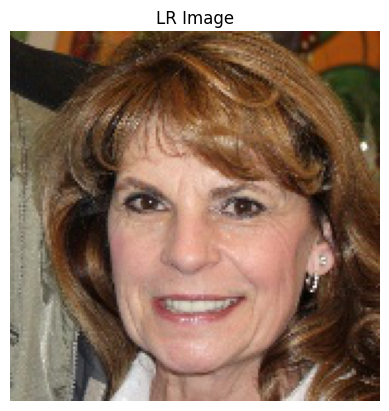

In [ ]:
plt.imshow(np_img)
plt.axis("off")
plt.title("LR Image")

In [ ]:
print(pred.shape)

(1, 510, 510, 3)


Text(0.5, 1.0, 'HR Image')

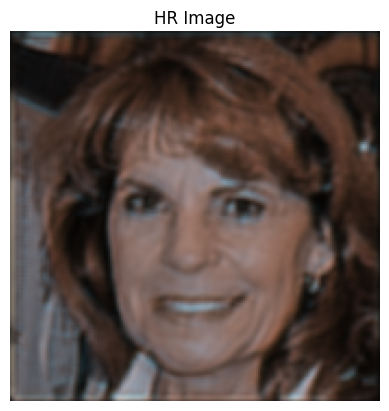

In [ ]:
plt.imshow(pred.reshape((510,510,3)).astype('uint8'))
plt.axis("off")
plt.title("HR Image")